## Import

In [52]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd

from model import (
    load_features,
    train_test_split,
    train_xgboost,
    evaluate_models,
    walk_forward_xgboost
)
from config import RESULTS_DIR


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [37]:
df = load_features()
df.head()

,Close,High,Low,Open,Volume,log_return,volatility_20d,abs_return,return_squared,lag_1,lag_5,lag_10,lag_20,rolling_abs_return_mean_20d,target_volatility
Date,,,,,,,,,,,,,,,
1993-03-02,24.866394,24.866394,24.485962,24.520547,182400,0.014711,0.132772,0.014711,0.000216,-0.002819,-0.000715,-0.025551,0.007088,0.005358,0.109394
1993-03-03,24.970148,24.987440,24.866394,24.900979,280100,0.004164,0.133246,0.004164,0.000017,0.014711,0.012794,-0.000720,0.002116,0.005460,0.108620
1993-03-04,24.831806,25.004730,24.831806,25.004730,89500,-0.005556,0.129993,0.005556,0.000031,0.004164,0.002116,-0.000719,0.010516,0.005212,0.107370
1993-03-05,24.762632,24.970140,24.745340,24.866386,40000,-0.002790,0.129425,0.002790,0.000008,-0.005556,0.001409,0.003593,0.004176,0.005143,0.131427
1993-03-08,25.315989,25.315989,24.814511,24.814511,50800,0.022100,0.151810,0.022100,0.000488,-0.002790,-0.002819,0.003580,-0.000695,0.006213,0.103420


## Test Train Chronological Split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df)

Train: (6586, 8), Test: (1647, 8)


## Train model

In [39]:
xgb_model = train_xgboost(X_train, y_train)

## Predict 

In [40]:

y_pred = xgb_model.predict(X_test)

## Evaluate

In [41]:
metrics = evaluate_models(y_test, y_pred, model_name="XGBoost")

## XGBoost: Predicted vs True Volatility chart

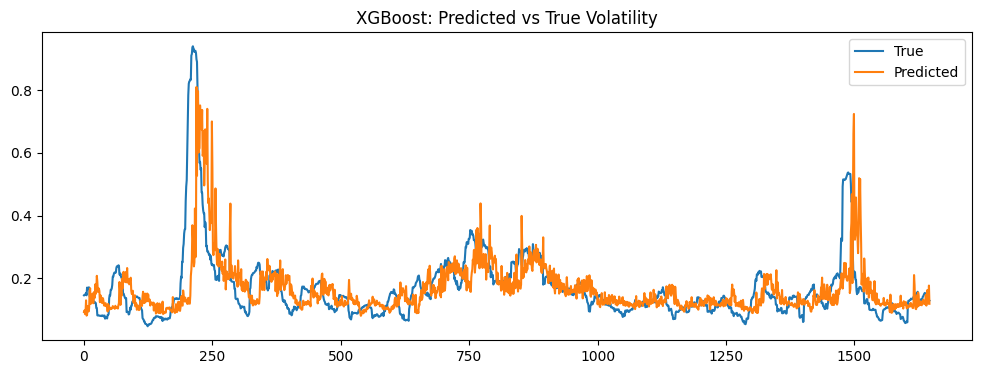

In [42]:
plt.figure(figsize=(12,4))
plt.plot(y_test.values, label="True")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("XGBoost: Predicted vs True Volatility")
plt.savefig(f"{RESULTS_DIR}/figures/xgboost/Predicted_vs_True_Volatility.png", dpi=300, bbox_inches="tight")


## Walk forward validation (retrain every 20 days)

In [53]:
print("\n" + "="*50)
print("WALK-FORWARD VALIDATION (retrain every 20 days)")
print("="*50)
y_pred_walkforward = walk_forward_xgboost(X_train, X_test, y_train, y_test, retrain_frequency=20)
metrics_walkforward = evaluate_models(y_test, y_pred_walkforward, model_name="XGBoost_WalkForward")
print(f"Walk-forward - RMSE: {metrics_walkforward['rmse']:.4f}, R²: {metrics_walkforward['R_squared']:.4f}")


WALK-FORWARD VALIDATION (retrain every 20 days)
Starting walk-forward validation...
Initial train size: 6586, Test size: 1647
Retraining every 20 days
Day 0/1647: Retraining model (train size: 6586)...
Day 20/1647: Retraining model (train size: 6606)...
Day 40/1647: Retraining model (train size: 6626)...
Day 60/1647: Retraining model (train size: 6646)...
Day 80/1647: Retraining model (train size: 6666)...
Day 100/1647: Retraining model (train size: 6686)...
Day 120/1647: Retraining model (train size: 6706)...
Day 140/1647: Retraining model (train size: 6726)...
Day 160/1647: Retraining model (train size: 6746)...
Day 180/1647: Retraining model (train size: 6766)...
Day 200/1647: Retraining model (train size: 6786)...
Day 220/1647: Retraining model (train size: 6806)...
Day 240/1647: Retraining model (train size: 6826)...
Day 260/1647: Retraining model (train size: 6846)...
Day 280/1647: Retraining model (train size: 6866)...
Day 300/1647: Retraining model (train size: 6886)...
Day 32

## Walk-forward v Standard Results

In [55]:
print("\n" + "="*50)
print("COMPARISON")
print("="*50)
comparison = pd.DataFrame([metrics, metrics_walkforward])
print(comparison)


COMPARISON
                 model      rmse       mae  R_squared
0              XGBoost  0.100136  0.056176   0.234745
1  XGBoost_WalkForward  0.100627  0.057046   0.227231


## Save Predictions 

In [48]:
preds_df = pd.DataFrame({
    "target_vol": y_test.values,
    "xgb_pred": y_pred,
})
preds_df.to_csv(RESULTS_DIR / "preds" / "xgboost_preds.csv", index=False)
print(f"Predictions saved to {RESULTS_DIR / 'preds' / 'xgboost_preds.csv'}")

Predictions saved to C:\Users\hp\Financial-volatility-forecasting\results\preds\xgboost_preds.csv


## Feature importance

In [43]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Features:")
print(importance_df.head(10))



Top 10 Features:
                       feature  importance
7  rolling_abs_return_mean_20d    0.616960
0               volatility_20d    0.184639
3                        lag_1    0.057947
1                   abs_return    0.041935
4                        lag_5    0.034592
5                       lag_10    0.032152
6                       lag_20    0.031775
2               return_squared    0.000000


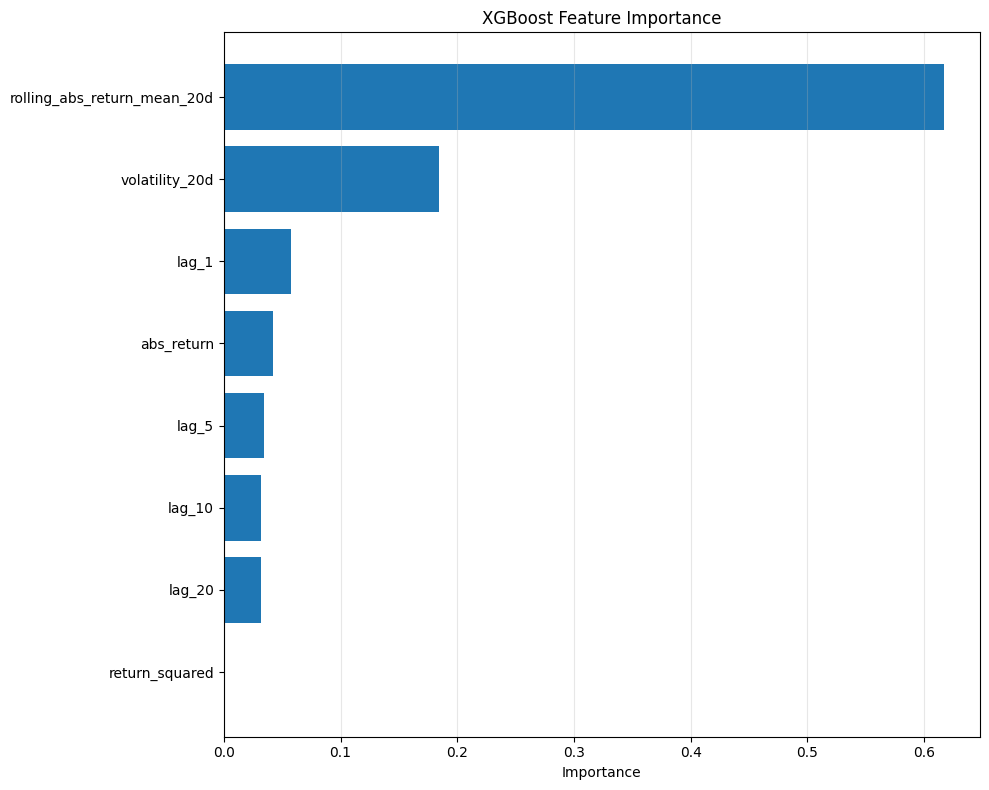

In [44]:
plt.figure(figsize=(10, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importance')
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/figures/xgboost/feature_importance.png", dpi=300, bbox_inches="tight")

## Save Metrics

In [45]:
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(RESULTS_DIR / "metrics" / "xgboost_metrics.csv", index=False)
print(f"\n✅ Metrics saved to {RESULTS_DIR / 'metrics' / 'xgboost_metrics.csv'}")



✅ Metrics saved to C:\Users\hp\Financial-volatility-forecasting\results\metrics\xgboost_metrics.csv
